In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

## Get tree and pmat data

In [2]:
scite_input_path = '../../../mt-SCITE/mt-SCITE_output/stdout/'
scite_stdout_filenames = list(glob(os.path.join(scite_input_path, '*.txt')))
scite_stdout_filenames

['../../../mt-SCITE/mt-SCITE_output/stdout/0.002.stdout.txt',
 '../../../mt-SCITE/mt-SCITE_output/stdout/0.0003.stdout.txt',
 '../../../mt-SCITE/mt-SCITE_output/stdout/0.0006.stdout.txt',
 '../../../mt-SCITE/mt-SCITE_output/stdout/0.00009.stdout.txt',
 '../../../mt-SCITE/mt-SCITE_output/stdout/0.0001.stdout.txt',
 '../../../mt-SCITE/mt-SCITE_output/stdout/0.0004.stdout.txt',
 '../../../mt-SCITE/mt-SCITE_output/stdout/0.005.stdout.txt',
 '../../../mt-SCITE/mt-SCITE_output/stdout/0.0009.stdout.txt',
 '../../../mt-SCITE/mt-SCITE_output/stdout/0.00005.stdout.txt',
 '../../../mt-SCITE/mt-SCITE_output/stdout/0.0007.stdout.txt',
 '../../../mt-SCITE/mt-SCITE_output/stdout/0.025.stdout.txt',
 '../../../mt-SCITE/mt-SCITE_output/stdout/0.0002.stdout.txt',
 '../../../mt-SCITE/mt-SCITE_output/stdout/0.0005.stdout.txt',
 '../../../mt-SCITE/mt-SCITE_output/stdout/0.0008.stdout.txt',
 '../../../mt-SCITE/mt-SCITE_output/stdout/0.03.stdout.txt',
 '../../../mt-SCITE/mt-SCITE_output/stdout/0.001.stdout.tx

In [3]:
pmat_input_path = '../../data/P9855_matrix_output/'
pmats = list(glob(os.path.join(pmat_input_path, '*.csv')))
pmats

['../../data/P9855_matrix_output/0.005.csv',
 '../../data/P9855_matrix_output/0.002.csv',
 '../../data/P9855_matrix_output/0.00009.csv',
 '../../data/P9855_matrix_output/0.001.csv',
 '../../data/P9855_matrix_output/0.0001.csv',
 '../../data/P9855_matrix_output/0.0003.csv',
 '../../data/P9855_matrix_output/0.0002.csv',
 '../../data/P9855_matrix_output/0.0006.csv',
 '../../data/P9855_matrix_output/0.0007.csv',
 '../../data/P9855_matrix_output/0.0005.csv',
 '../../data/P9855_matrix_output/0.0004.csv',
 '../../data/P9855_matrix_output/0.0009.csv',
 '../../data/P9855_matrix_output/0.0008.csv',
 '../../data/P9855_matrix_output/0.03.csv',
 '../../data/P9855_matrix_output/0.025.csv',
 '../../data/P9855_matrix_output/0.00005.csv']

In [4]:
# Get experiment IDs
experiments = []
for filename in sorted(scite_stdout_filenames):
    name = os.path.basename(filename).split('-')[0].rsplit('.', 2)[0]
    experiments.append(name)

In [5]:
# Get log likelihood scores
lhood = []
for filename in sorted(scite_stdout_filenames):
    file = open(filename, "r")
    for line in file:
        if 'best log score for tree:' in line:
            score = line.split('	')[1].rstrip()
            lhood.append(score)

In [6]:
# Get n mutations
n_mut = []
for filename in sorted(pmats):
    file = open(filename, "r")
    n = len(file.readlines())
    n_mut.append(n)

In [8]:
#tree_data['n_muts']/tree_data['lhood']

In [9]:
# Create df
samples = 12
tree_data = pd.DataFrame(experiments)
tree_data['lhood'] = lhood
tree_data['n_muts'] = n_mut
tree_data['lhood'] = tree_data['lhood'].astype(float)
tree_data['lhood_mut'] = tree_data['lhood']/tree_data['n_muts']
tree_data['entries'] = tree_data['n_muts']*samples
tree_data['lhood_entries'] = tree_data['lhood']/tree_data['entries']
tree_data = tree_data.rename(columns={0: 'error_rate'})
tree_data = tree_data.set_index('error_rate')
tree_data

,lhood,n_muts,lhood_mut,entries,lhood_entries
error_rate,,,,,
0.00005,-11886.137229,1018,-11.675970,12216,-0.972997
0.00009,-2104.634643,239,-8.806003,2868,-0.733834
0.0001,-1665.747970,193,-8.630818,2316,-0.719235
0.0002,-389.108193,66,-5.895579,792,-0.491298
0.0003,-129.650810,41,-3.162215,492,-0.263518
0.0004,-124.117935,34,-3.650527,408,-0.304211
0.0005,-105.449658,34,-3.101461,408,-0.258455
0.0006,-58.557062,30,-1.951902,360,-0.162659
0.0007,-38.863853,28,-1.387995,336,-0.115666


## Plots

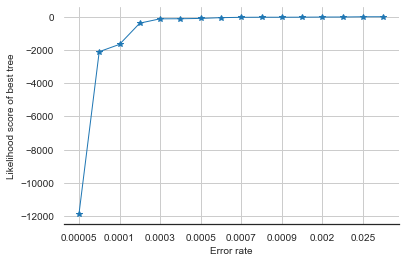

In [10]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    tree_data.lhood.plot(marker='*', lw=1)
    plt.grid(axis='both')
    plt.xlabel('Error rate')
    plt.ylabel('Likelihood score of best tree')
    #plt.savefig('../../data/P9855_figures/P9855_lhood.svg', dpi=300, bbox_inches='tight', transparent=True)

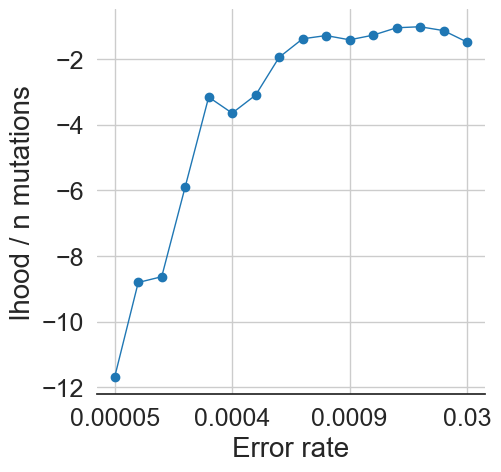

In [11]:
with plot_style(figsize=(5, 5), ticklabelsize=18, labelsize=20):
    tree_data.lhood_mut.plot(marker='o', lw=1)
    plt.grid(axis='both')
    #plt.xscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('lhood / n mutations')
    #plt.savefig('figs/performance/train_atac_log_lhood.png', dpi=300)

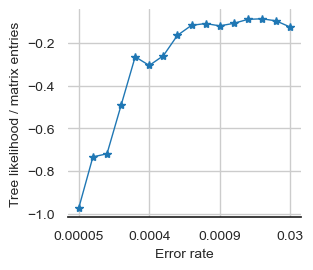

In [12]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    tree_data.lhood_entries.plot(marker='*', lw=1)
    plt.grid(axis='both')
    #plt.xscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Tree likelihood / matrix entries')
    plt.savefig('../../data/P9855_figures/P9855_lhood_entries.svg', dpi=300, bbox_inches='tight', transparent=True)

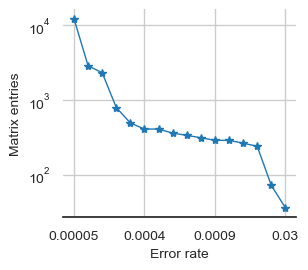

In [13]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    tree_data.entries.plot(marker='*', lw=1)
    plt.grid(axis='both')
    plt.yscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Matrix entries')
    plt.savefig('../../data/P9855_figures/P9855_entries.svg', dpi=300, bbox_inches='tight', transparent=True)
    #plt.savefig('figs/performance/train_atac_log_lhood.png', dpi=300)